<a href="https://colab.research.google.com/github/adsmetanina/hunter-college-data-week/blob/main/draft_data_week_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit Risk Predictions w/ Macro Shocks \
Datasets from LendingClub Loan (borrower demographics, loan terms, repayment and default), FRED Macroeconomic Data (unemployment rate, GDP growth, Federal Reserve fund rates, credit spreads) \
Research Question: Do macroeconomic shocks improve machine learning models of household credit risk beyond borrower-level characteristics?

In [1]:
# importing packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

In [2]:
# importing loan data
import kagglehub
path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lending-club-loan-data-csv


In [3]:
# setting loan data dataframe
df = pd.read_csv("/kaggle/input/lending-club-loan-data-csv/loan.csv")
df
print(df.columns.tolist())

/tmp/ipython-input-3272332638.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/lending-club-loan-data-csv/loan.csv")


['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_i

In [4]:
# keeping key vars
cols = ["loan_amnt", "term", "int_rate", "grade", "sub_grade", "emp_length", "home_ownership", "annual_inc", "dti", "purpose", "addr_state", "issue_d", "loan_status"]
df = df[cols]

In [5]:
# setting binary, 0 = paid & 1 = default
df = df[df["loan_status"].isin(["Charged Off", "Fully Paid"])]
df["default"] = (df["loan_status"] == "Charged Off").astype(int)

In [6]:
# importing macro data
unemp = web.DataReader("UNRATE", "fred")      # unemployment rate
fedfunds = web.DataReader("FEDFUNDS", "fred") # fed funds rate

In [7]:
# preparing macro data
macro = pd.concat([unemp, fedfunds], axis=1)
macro.columns = ["unemp","fedfunds"]
macro.index = pd.to_datetime(macro.index)

In [8]:
# merging loan data w/ monthly macro conditions on issue date
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")
df = df.merge(macro, left_on="issue_d", right_index=True, how="left")

In [9]:
# preparing features and target
X = df.drop(columns=["loan_status", "default"])
y = df["default"]

# setting categorical and numerical columns (categorical needs one-hot encoding)
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# applying one-hot encoding to categorical features, and imputing missing numerical values w/ column means
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('passthrough', 'passthrough')]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# preprocessing on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['unemp' 'fedfunds']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['unemp' 'fedfunds']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [10]:
# training linear regression model
reg = LinearRegression()
reg.fit(X_train_processed, y_train)

# showing slope and intercept
slope = reg.coef_
intercept = reg.intercept_
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# evaluating the model
y_pred = reg.predict(X_test_processed)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# getting feature names after preprocessing for coefficient analysis
feature_names = preprocessor.get_feature_names_out()
coef_table = pd.DataFrame({
    "feature": feature_names,
    "slope": reg.coef_
})
print(coef_table.sort_values("slope", key=abs, ascending=False).head(15))

Slope: [ 1.75529765e-06  2.04954304e-02 -1.73663347e-07  1.66371715e-03
 -1.22151002e-03  1.22151002e-03 -1.02603628e-03 -8.25433187e-04
  3.11539889e-04  6.56843836e-04  5.42348504e-04  2.55451779e-04
  8.52854603e-05 -2.13389399e-04 -1.78139034e-04 -1.73078947e-04
 -2.19736150e-04 -2.41692751e-04 -2.13241827e-04 -2.08800599e-04
 -1.92084362e-04 -1.32748798e-04 -7.85576012e-05 -2.29623476e-05
  2.37675161e-05  6.80746609e-05  1.16671882e-04  1.25988178e-04
  1.27943615e-04  1.35527653e-04  1.29236736e-04  1.41182972e-04
  1.22952860e-04  1.22422957e-04  1.17907038e-04  1.08243963e-04
  9.63889007e-05  9.73856448e-05  7.04307040e-05  5.47565260e-05
  4.89974829e-05  4.35675658e-05  3.76995005e-05  2.64133916e-05
  1.92510473e-05  1.60013125e-05  1.20132564e-05  1.16064526e-05
  2.53676547e-05 -2.40947883e-04 -1.98477956e-06  9.26553525e-06
  2.51044295e-06 -6.42575451e-06 -1.45692338e-05 -1.63240833e-05
  4.86958139e-06 -2.15523836e-06  3.04289502e-05  2.09964808e-04
 -9.19789441e-08 -

In [11]:
# training logistic regression model
logit = LogisticRegression(max_iter=2000, n_jobs=-1)
logit.fit(X_train_processed, y_train)

print("Intercept (log-odds):", logit.intercept_[0])

y_proba = logit.predict_proba(X_test_processed)[:, 1]
y_hat = (y_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))
print("Accuracy (0.5 cutoff):", accuracy_score(y_test, y_hat))

# computing marginal effects
p = logit.predict_proba(X_test_processed)[:, 1]
avg_deriv_factor = np.mean(p * (1 - p))

betas = logit.coef_.ravel()
feature_names = preprocessor.get_feature_names_out()
marginal_effects = betas * avg_deriv_factor

me_table = pd.DataFrame({
    "feature": feature_names,
    "marginal_effect": marginal_effects
}).sort_values("marginal_effect", key=abs, ascending=False)

print("\n=== Average Marginal Effects (Top 15) ===")
print(me_table.head(15))

Intercept (log-odds): -0.920995155261088
ROC-AUC: 0.7048240510777986
Log Loss: 0.4597154569059492
Accuracy (0.5 cutoff): 0.7999069251284254

=== Average Marginal Effects (Top 15) ===
                          feature  marginal_effect
6                    cat__grade_A        -0.143215
4            cat__term_ 36 months        -0.099969
61   cat__home_ownership_MORTGAGE        -0.069266
7                    cat__grade_B        -0.061698
59            cat__emp_length_nan         0.056594
64        cat__home_ownership_OWN        -0.049040
13              cat__sub_grade_A1        -0.048753
14              cat__sub_grade_A2        -0.036731
18              cat__sub_grade_B1        -0.035923
5            cat__term_ 60 months        -0.033541
85             cat__addr_state_CO        -0.033474
127            cat__addr_state_WA        -0.032939
11                   cat__grade_F         0.031924
19              cat__sub_grade_B2        -0.030786
75             cat__purpose_other        -0.030666


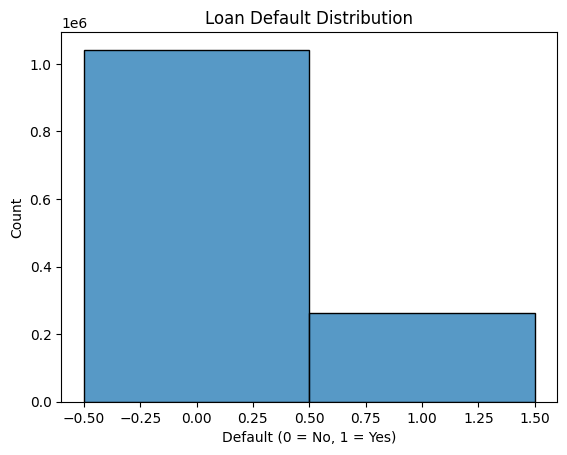

In [12]:
sns.histplot(data=df['default'], discrete=True)
plt.title("Loan Default Distribution")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

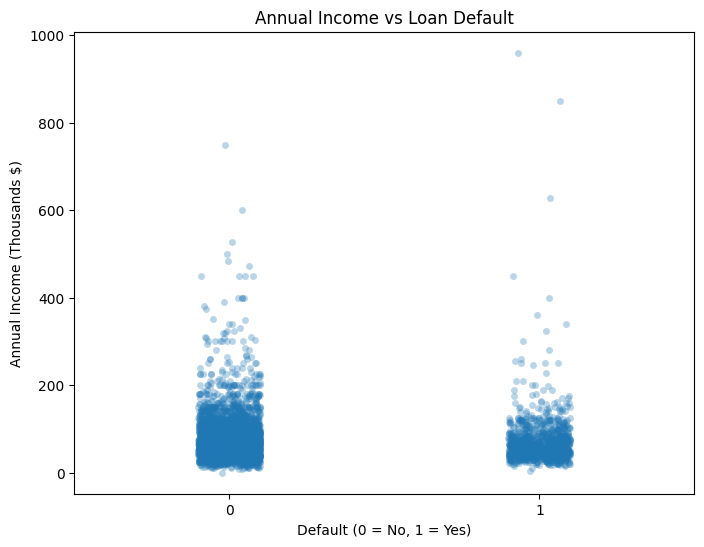

In [13]:
# people sit below $200k annual income (most borrowers are average income)
# both defaulters and nondefaulters show similar incomes
# some making $500k default
# income is not a strong predicter of default
df["income_thousands"] = df["annual_inc"] / 1000

plt.figure(figsize=(8,6))
sns.stripplot(
    data=df.sample(5000, random_state=42),
    x="default",
    y="income_thousands",
    alpha=0.3,
    jitter=True
)

plt.title("Annual Income vs Loan Default")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Annual Income (Thousands $)")
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89    312239
           1       0.54      0.05      0.09     78844

    accuracy                           0.80    391083
   macro avg       0.67      0.52      0.49    391083
weighted avg       0.75      0.80      0.73    391083

ROC-AUC: 0.7048240510777986


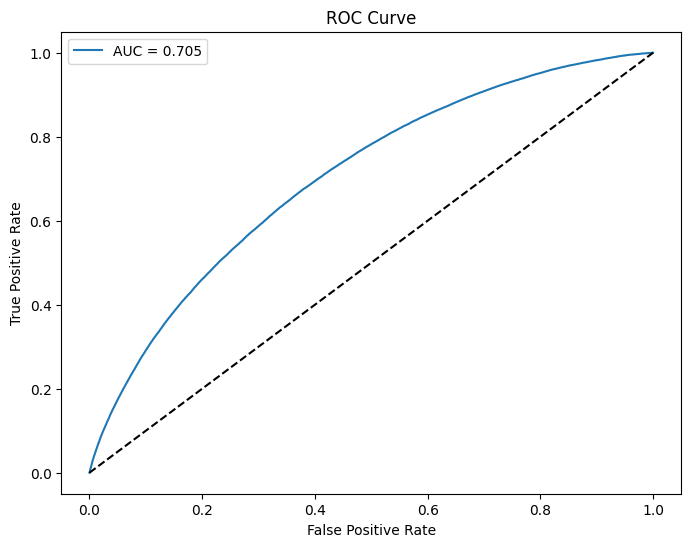

In [14]:
# roc shows percent of non-defaulters that were incorrectly predicted as defaulters (x-axis) and percent of defaulters that were incorrectly predicted as defaulters (y-axis)
# auc summarizes roc curve, auc = 0.705 means that the model is no better than random guessing
print("Classification Report:\n", classification_report(y_test, y_hat))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()